# Predicting Bankruptcy with Financial Data

In this project I look at financial data for companies listed on Taiwan's stock exchange between 1999 and 2009 and test a series of models that use this data to predict which companies are likely to go bankrupt. A model like this can help investors or fund managers to assess the risk of holding stock in a given company as well as the opportunities and risks of short selling a company's stock. This is purely an educational project so none of the recommendations in it should be construed as financial advice.

I'm going to be evaluating the performance of my models primarily based on the F1 scores for the bankruptcy class, since this number incorporates both:

1. What percentage of our bankruptcy predictions are correct (precision), and
2. What percentage of all bankruptcies our predictions account for (recall).

F1 is defined as:

    2 * precision * recall / (precision + recall)

### Importing Libraries and Inspecting Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,\
classification_report, plot_confusion_matrix, precision_recall_curve

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.ensemble import RandomForestClassifier

In [2]:
# inspecting the dataset
df = pd.read_csv('data/data.csv')
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [3]:
#looking for null or non-numeric values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

There are no null or non-numeric values.

Looking at the top of our dataframe, it appears that scaling may have already been done on the data. For example, the columns with ROA (return on assets) values include numbers that seem quite high, which suggests that the column has been min-max scaled. To investigate this question further we'll look at summary statistics for our columns.

#### Eliminating inconsistently scaled columns

In [4]:
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


As we can see above, the max and min values for most columns are 0 and 1, which almost certainly means that these columns have been min-max scaled. Below we'll look at the summary statistics for the columns have not been min-max scaled (i.e. the columns with max values greater than 1). 

In [5]:
max_vals = df.describe().loc['max',:]
description = df[max_vals[max_vals !=1].index].describe().transpose()
description

,count,mean,std,min,25%,50%,75%,max
Operating Expense Rate,6819.0,1.995347e+09,3.237684e+09,0.0,1.566874e-04,2.777589e-04,4.145000e+09,9.990000e+09
Research and development expense rate,6819.0,1.950427e+09,2.598292e+09,0.0,1.281880e-04,5.090000e+08,3.450000e+09,9.980000e+09
Interest-bearing debt interest rate,6819.0,1.644801e+07,1.082750e+08,0.0,2.030203e-04,3.210321e-04,5.325533e-04,9.900000e+08
Revenue Per Share (Yuan ¥),6819.0,1.328641e+06,5.170709e+07,0.0,1.563138e-02,2.737571e-02,4.635722e-02,3.020000e+09
Total Asset Growth Rate,6819.0,5.508097e+09,2.897718e+09,0.0,4.860000e+09,6.400000e+09,7.390000e+09,9.990000e+09
Net Value Growth Rate,6819.0,1.566212e+06,1.141594e+08,0.0,4.409689e-04,4.619555e-04,4.993621e-04,9.330000e+09
Current Ratio,6819.0,4.032850e+05,3.330216e+07,0.0,7.555047e-03,1.058717e-02,1.626953e-02,2.750000e+09
Quick Ratio,6819.0,8.376595e+06,2.446847e+08,0.0,4.725903e-03,7.412472e-03,1.224911e-02,9.230000e+09
Total debt/Total net worth,6819.0,4.416337e+06,1.684069e+08,0.0,3.007049e-03,5.546284e-03,9.273293e-03,9.940000e+09
Accounts Receivable Turnover,6819.0,1.278971e+07,2.782598e+08,0.0,7.101336e-04,9.678107e-04,1.454759e-03,9.740000e+09


In almost all these cases, the max values are close to 10 billion, while median values are below 1. This suggests that data for these columns may be inconsistently scaled. There are two possible solutions. We could drop rows for high values or we could drop columns. The problem with dropping rows is that we would be biasing our data set against high values, thereby distorting our results. For this reason, I'll instead be dropping columns that haven't been min-max scaled.

In [6]:
df = df.drop(max_vals[max_vals !=1].index, axis=1)

#### Inspecting target variable distribution

In [7]:
# checking target variable distribution
df['Bankrupt?'].value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

In [8]:
# normalized target variable distribution
df['Bankrupt?'].value_counts(normalize=True)

0    0.967737
1    0.032263
Name: Bankrupt?, dtype: float64

As we can see, the data set is highly imbalanced -- only 3% of companies represented went bankrupt. This means that we could easily get a 97% accuracy score by predicting that no companies went bankrupt. However, this would also yield an undefined precision and a 0% recall for predicting bankruptcies.

### Eliminating Perfectly Correlated Variables

In [9]:
#looking for collinearity of predictive variables
# code from https://github.com/learn-co-curriculum/dsc-multicollinearity-of-features
predictors = df.drop('Bankrupt?', axis=1)

predictor=predictors.corr().abs().stack().reset_index().sort_values(0, ascending=False)

predictor['pairs'] = list(zip(predictor.level_0, predictor.level_1))
predictor.set_index(['pairs'], inplace = True)
predictor.drop(columns=['level_1', 'level_0'], inplace = True)
predictor.columns = ['correlations']
predictor.drop_duplicates(inplace=True)

predictor[(predictor['correlations']<1)&(predictor['correlations']>=0.99)]

,correlations
pairs,
"( Debt ratio %, Net worth/Assets)",1.000000
"( Gross Profit to Sales, Operating Gross Margin)",1.000000
"( Net Value Per Share (C), Net Value Per Share (A))",0.999837
"( Realized Sales Gross Margin, Operating Gross Margin)",0.999518
"( Realized Sales Gross Margin, Gross Profit to Sales)",0.999518
"( Net Value Per Share (A), Net Value Per Share (B))",0.999342
"( Net Value Per Share (B), Net Value Per Share (C))",0.999179
"( Operating Profit Per Share (Yuan ¥), Operating profit/Paid-in capital)",0.998696
"( After-tax Net Profit Growth Rate, Regular Net Profit Growth Rate)",0.996186


Because we'll be using regularization for feature selection, we don't need to be aggressive in paring down features at this point. However, the top two pairs are perfectly correlated because they correspond to the accounting identity:

Debt ratio % = 1 - Net worth/Assets 

and the definitional identity

Gross Profit to Sales = Operating Gross Margin

So there's no possible reason why we would want to keep them. It's possible that some of the differences between the other features may be important for future models so we'll leave them in.

In [10]:
## Eliminating perfectly correlated variables

df = df.drop([' Debt ratio %', ' Gross Profit to Sales'], axis=1)

### Splitting Data

In [11]:
#splitting predictor and target variables

y= df['Bankrupt?']
X = df.drop('Bankrupt?', axis=1)

In [12]:
#splitting data into training set and testing set

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## First model: Logistic Regression

I'll first build a linear regression model, using gridsearch to choose between Lasso and Ridge regression and to tune the regularization parameter C. I'm including a standard scaler in the pipeline, which will allow us to interpret feature effects in terms of z-scores. I'm also balancing the weight of the classes so that the model won't be biased towards predicting the majority class. 

In [13]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('logreg', LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=500, random_state=42))])

grid = [{'logreg__penalty': ['l1', 'l2'],
         'logreg__C': [np.e**i for i in range(-2, 3)],
        }]

gs_logreg = GridSearchCV(estimator=pipe,
                         param_grid=grid,
                         scoring='f1',
                         cv=5)

In [14]:
gs_logreg.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=500,
                                                           random_state=42,
                                                           solver='liblinear'))]),
             param_grid=[{'logreg__C': [0.1353352832366127, 0.36787944117144233,
                                        1.0, 2.718281828459045,
                                        7.3890560989306495],
                          'logreg__penalty': ['l1', 'l2']}],
             scoring='f1')

### Regularization of Logistic Regression Model

Below we see that GridSearch selected Lasso (L1) Regularization, with a regularization hyper-parameter of e^-1. In the next cell, we see that regularization trimmed 21 features from the model by bringing their coefficients down to zero.

In [15]:
gs_logreg.best_params_

{'logreg__C': 0.36787944117144233, 'logreg__penalty': 'l1'}

In [16]:
coefs = pd.DataFrame(gs_logreg.best_estimator_.steps[1][1].coef_, columns=X.columns)
coefs = coefs.transpose()
coefs.rename(columns={0:'coefficient'}, inplace=True)
coefs['|coefficient|']=coefs['coefficient'].abs()
coefs[coefs['coefficient']==0].shape[0]

21

And here we can see the five largest coefficients in our model by absolute value.

In [17]:
coefs.sort_values('|coefficient|', ascending=False).head()

,coefficient,|coefficient|
Persistent EPS in the Last Four Seasons,-2.136638,2.136638
Operating profit/Paid-in capital,1.864492,1.864492
Net worth/Assets,-1.638927,1.638927
Borrowing dependency,1.370497,1.370497
Inventory and accounts receivable/Net value,-0.910537,0.910537


### Performance of Logistic Regression Model

Below are the confusion matrices and classification reports for our Logistic Regression Model. It looks like the model is overfitting on the training data, since it gives us a bankruptcy recall of 91% on the training data and only 81% on the testing data at a 50% probability threshold. However, because bankruptcies make up only 3% of the data set, we might expect this difference to be a result of random bias in the train test split rather than overfitting. There is only a 3% decline in f1, which is a more relevant indication of the model's variance. This hypothesis is supported by the fact that the gridsearch selected C=e^-1 over more aggressive regularization that would in theory have reduced overfitting if it was occuring.

#### Logistic Regression Training Results

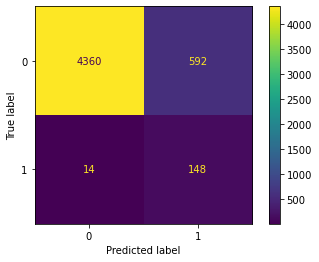

In [18]:
plot_confusion_matrix(gs_logreg, X_train, y_train)

In [19]:
y_pred = gs_logreg.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94      4952
           1       0.20      0.91      0.33       162

    accuracy                           0.88      5114
   macro avg       0.60      0.90      0.63      5114
weighted avg       0.97      0.88      0.92      5114



#### Logistic Regression Testing Results

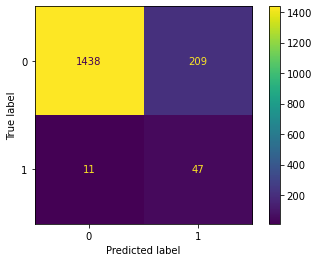

In [20]:
plot_confusion_matrix(gs_logreg, X_test, y_test)

In [21]:
y_pred = gs_logreg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93      1647
           1       0.18      0.81      0.30        58

    accuracy                           0.87      1705
   macro avg       0.59      0.84      0.61      1705
weighted avg       0.96      0.87      0.91      1705



###  The Precision Recall Curve

Since finance is inherently based on risk and uncertainty, these results shouldn't necessarily be discouraging. Our model's decision function is based on a 50% probability threshold but we can easily change this threshold if we want to adjust the balance between precision and recall. 

The Precision Recall curve below shows how increasing the probability threshold for our decision function affects the precision/recall tradeoff. On the curve we plot four vertical lines that correspond to:

- maximal precision threshold
- 50% precision threshold
- 50% probability threshold
- maximal recall threshold

In [22]:
#getting probabilities for decision function

y_probs = [n[1] for n in gs_logreg.predict_proba(X_test)]

# getting precision recall curve

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# creating a dataframe to for precision recall tradeoff

thresholds_df = pd.DataFrame(thresholds.reshape(-1,1), columns=['thresholds'])
precision_df = pd.DataFrame(precision.reshape(-1,1), columns=['precision'])
recall_df = pd.DataFrame(recall.reshape(-1,1), columns=['recall'])

precision_recall_df = pd.concat([thresholds_df, recall_df, precision_df], axis=1)

In [23]:
# using data frame to find probability threshold that maximizes precision
precision_recall_df.sort_values('precision', ascending=False).head(10)

,thresholds,recall,precision
1703,NaN,0.000000,1.000000
1702,1.000000,0.017241,1.000000
1701,0.999984,0.034483,1.000000
1700,0.999969,0.051724,1.000000
1699,0.999926,0.068966,1.000000
1698,0.999896,0.086207,1.000000
1697,0.999894,0.103448,1.000000
1693,0.999001,0.155172,0.900000
1694,0.999531,0.137931,0.888889
1695,0.999637,0.120690,0.875000


In [24]:
# finding threshold that results in 50% precision

precision_recall_df.sort_values('precision', ascending=False)[(precision_recall_df['precision']>0.499)&(precision_recall_df['precision']<0.501)]

/var/folders/gs/xqppcy254vd2q7ybhjlcr_pr0000gn/T/ipykernel_1074/135742946.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  precision_recall_df.sort_values('precision', ascending=False)[(precision_recall_df['precision']>0.499)&(precision_recall_df['precision']<0.501)]


,thresholds,recall,precision
1661,0.954154,0.362069,0.5
1659,0.951774,0.379310,0.5
1655,0.943600,0.413793,0.5


In [25]:
# finding recall that corresponds to 50% probability

precision_recall_df.sort_values('precision', ascending=False)[(precision_recall_df['thresholds']>0.499)&(precision_recall_df['thresholds']<0.501)]

/var/folders/gs/xqppcy254vd2q7ybhjlcr_pr0000gn/T/ipykernel_1074/1481358799.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  precision_recall_df.sort_values('precision', ascending=False)[(precision_recall_df['thresholds']>0.499)&(precision_recall_df['thresholds']<0.501)]


,thresholds,recall,precision
1446,0.499918,0.810345,0.182879


In [26]:
#finding the probability threshold for maximum recall

precision_recall_df.sort_values('thresholds').head()

,thresholds,recall,precision
0,1.558319e-27,1.000000,0.034058
1,6.928471e-14,0.982759,0.033490
2,7.343045e-10,0.982759,0.033510
3,4.249954e-09,0.982759,0.033529
4,2.321607e-07,0.982759,0.033549


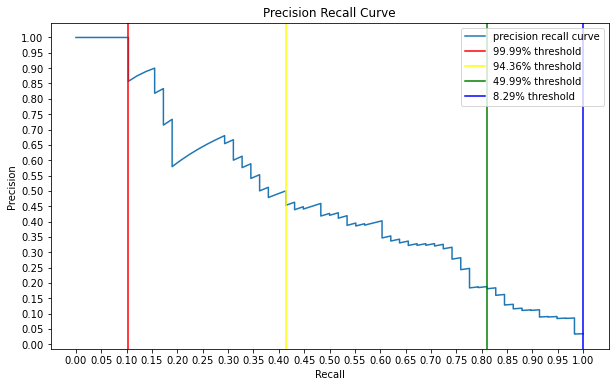

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(recall, precision, label='precision recall curve')

ax.set_yticks([i/20.0 for i in range(21)])
ax.set_xticks([i/20.0 for i in range(21)])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall Curve')
ax.axvline(x=0.103448, label='99.99% threshold', color='red')
ax.axvline(x=0.413793, label='94.36% threshold', color='yellow')
ax.axvline(x=0.810345, label='49.99% threshold', color='green')
ax.axvline(x=1.00, label='8.29% threshold', color='blue')
plt.legend(loc='upper right')
plt.show()

These four lines correspond to the following investment strategies.

##### Blue: Below threshold, go long

The blue line on the right (8.29% predicted probability of bankruptcy) represent the most conservative decision threshold. If we had guessed that every company above the 8.29% threshold would go bankrupt, 92% of the companies we labeled as bankrupt would have been false positives, but we would have also succeeded at finding every bankrupt company. If funds and investors are trying to minimize exposure to risk, even if it means missing out on potential profits, then they should only invest in companies that fall below the 8.29% bankruptcy probability threshold.

##### Red: Above threshold, go short

The red line on the left is also a conservative threshold (99.99% probability of bankruptcy), since every company in the test set that had a bankruptcy probability above 99.99% did in fact go bankrupt. While it's likely that the market is already bearish on these stocks and that this bearishness is already a part of our model, bankruptcy would likely reduce their value to zero, meaning that investors might be able to profit from shorting these stocks before they reach that point.

##### Yellow: Below threshold, don't go short

The yellow line represents the point at which our decision function yielded the same number of true positives and false positives in its bankruptcy predictions. This takes places when we set our probability threshold at 94.36%. Assuming that this is the only information we have, we shouldn't short stocks of companies that have less than 94.36% chance of bankruptcy, since below this threshold, we can expect every gain to be offset by a loss.

##### Green: Above threshold, don't go long

The green line represents the decision function using a 50% probability threshold, which is what we evaluated in our confusion matrix and classification report. This probability threshold is most useful to investors who are trying to balance opportunity with risk exposure. Investors who own a representative selection of stocks below this threshold are likely to see a 1% loss due to bankruptcies (as opposed to 3% from random investments), but may also see substantial returns from their willingness to go long on other stocks in this category.

Below, we can see how many companies fall to the left or the right of the thresholds described above.

In [28]:
#companies with minimal (8.29%) likelihood of bankruptcy--no false negatives in test data.

probs_df = pd.DataFrame(y_probs, columns=['probabilities'])
probs_df[probs_df['probabilities']<0.0829].shape[0]

912

In [29]:
#companies with maximal (99.99%) likelihood of bankruptcy--no false positives in test data:

probs_df[probs_df['probabilities']>0.9999].shape[0]

4

In [30]:
# companies with minimum 94.36% likelihood of bankruptcy--equal number of false positive and false negatives 
# in test data 

probs_df[probs_df['probabilities']>0.9436].shape[0]

48

In [31]:
# companies with maximum 50.00% likelihood of bankruptcy--1% false negatives in test data.

probs_df[probs_df['probabilities']<0.5].shape[0]

1449

### Test Cases

Let's see the accuracy of this model's predictions on the first five rows of the testing set.

In [32]:
predictions = pd.DataFrame(gs_logreg.predict(X_test.iloc[:5,:]).reshape(-1,1), columns=['predictions'])
actual = pd.DataFrame(y_test.iloc[:5])
actual.reset_index(drop=True, inplace=True)
probabilities = pd.DataFrame(gs_logreg.predict_proba(X_test.iloc[:5,:]), columns=['prob 0', 'prob 1'])
pd.concat([predictions, actual, probabilities], axis=1)

,predictions,Bankrupt?,prob 0,prob 1
0,0,0,0.947431,0.052569
1,0,0,0.872051,0.127949
2,0,0,0.994454,0.005546
3,1,1,0.056240,0.943760
4,1,0,0.379175,0.620825


As we see above, out of the first five predictions in our test set, we have three true negatives, one true positive, and one false positive. In the case of the false positive (Row 4), our decision function gave 62% odds that this company would go bankrupt, so it's unsurprising that this guess turned out to be wrong, since we would expect predictions with this probability to be wrong in one out of three cases. On the other hand, the value of the probability prediction was 94% for Row 3, so it's not surprising that this prediction turned out to be correct, since we should expected predictions with this probability to be wrong in only 6 out of 100 cases.

Next, we'll look at both the true positive (the company that did go bankrupt) and false positive (the company that didn't) in closer detail.

#### Function for getting top probability factors per row

In [33]:
def get_probability_factor_table(row):
    
    #comparing data for the true positive with summary statistics
    comparison = pd.concat([X_test.iloc[row,:], X.mean(), X.std()], axis=1) 
    
    # renaming columns
    comparison.rename(columns={X_test.iloc[row,:].name: 'sample', 0: 'mean', 1: 'std'}, inplace=True) 
    
    #engineering z-scores
    comparison['z_score'] = ((comparison['sample'] - comparison['mean'])/comparison['std']) 
    
    #merging with model coefficients dataframe
    comparison = comparison.merge(coefs, how='inner', left_on=comparison.index, right_on=coefs.index) 
    
    # dropping absolute value
    comparison = comparison.drop('|coefficient|', axis=1) 
       
    #calculating probability factor for each coefficient
    comparison['probability factor'] = np.e**(comparison['z_score']*comparison['coefficient']) 
    
    #renaming first column 'feature'
    comparison.rename(columns={'key_0': 'feature'}, inplace=True)
    
    #return top of data frame
    return comparison.sort_values(by='probability factor', ascending=False).head()
    

#### Test Case 1: The True Positive

In [34]:
get_probability_factor_table(3)

,feature,sample,mean,std,z_score,coefficient,probability factor
27,Net worth/Assets,0.772682,0.886823,0.053920,-2.116846,-1.638927,32.116041
15,Persistent EPS in the Last Four Seasons,0.189279,0.228813,0.033263,-1.188549,-2.136638,12.673299
29,Borrowing dependency,0.393783,0.374654,0.016286,1.174512,1.370497,5.001135
61,Net Income to Total Assets,0.767650,0.807760,0.040332,-0.994496,-0.860077,2.352182
0,ROA(C) before interest and depreciation befor...,0.436942,0.505180,0.060686,-1.124437,-0.565790,1.889279


In the table above, the column 'sample' shows the values for a company that was correctly predicted to go bankrupt.

The z_score represents how many standard deviations the variable is from the mean. This means, for example, that if the ratio of net worth to assets is 1 standard deviation above the mean, that this raises the odds of bankruptcy by a factor of e^(-1.64 * z_score). If the z-score is positive, it means that the probability factor is less than 1 and the odds of bankruptcy are lowered. If the z-score is negative, then e is raised to a positive power and the probability of bankruptcy is raised.

This particular company has a very low z-score of -2.12 for its net worth/assets ratio. Since e^(-2.12 * -1.88)=32.12, this statistic raises the company's probability of bankruptcy by a factor of 32.12

Net worth = Assets - liabilities, which means that by definition, a company with a net/worth assets ratio that is over two standard deviations below the mean, has a debt to assets ratio that is two standard deviations above the mean. It shouldn't be at all surprising that this ratio had a large effect in predicting this company's bankruptcy. 

#### Test Case 2: The False Positive

In [35]:
get_probability_factor_table(4)

,feature,sample,mean,std,z_score,coefficient,probability factor
27,Net worth/Assets,0.817305,0.886823,0.053920,-1.289270,-1.638927,8.273182
29,Borrowing dependency,0.384317,0.374654,0.016286,0.593294,1.370497,2.254905
40,Cash/Total Assets,0.021855,0.124095,0.139251,-0.734210,-0.631090,1.589393
33,Inventory and accounts receivable/Net value,0.398743,0.402459,0.013324,-0.278913,-0.910537,1.289121
35,Net Worth Turnover Rate (times),0.027581,0.038595,0.036680,-0.300281,-0.596382,1.196119


Like before, the net worth/assets ratio is significantly lower than average, though in this case, it's only slightly more than one standard deviation below the mean. This raises the probability of bankruptcy by a factor of 8.27 rather than a factor of 32, so we can see why our probability function gives a smaller probability of bankruptcy.

### Evaluating Logistic Regression

Overall, logistic regression is very useful in spite of its lackluster f1-score. This is because we can easily quantity how we can expect precision and recall to change as we move along the precision recall curve. Since investors should care more about the performance of the portfolio as a whole than about correctly predicting the movement of individual stocks, this ability to quantify risk and establish thresholds for different risk categories makes logistic regression an extremely useful tool. It also allows us to easily identify the factors that are most influencing our algorithm's predictions and to use our domain knowledge to better understand how these factors might be affecting a company's bankruptcy risk.

## Decision Tree Classifier #1

We'll now fit a simple decision tree classifier on our model, using GridSearchCV to tune our hyper-parameters. I'm choosing low tree depths to generate a simple, interpretable model that won't overfit on the data. I'm leaving out leaf size specifications from the grid search since the classes are imbalanced and I want the model to be able to pick out smaller leaf sizes if necessary.

In [36]:
tree = DecisionTreeClassifier(random_state=42, class_weight='balanced')

grid = [{'criterion': ['gini', 'entropy'],
         'max_depth': [2, 3, 4]
        }]
gs_tree = GridSearchCV(estimator=tree, param_grid=grid, scoring='f1', cv=5)

In [37]:
gs_tree.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [2, 3, 4]}],
             scoring='f1')

In [38]:
gs_tree.best_params_

{'criterion': 'entropy', 'max_depth': 2}

#### Decision Tree Results - Training Data

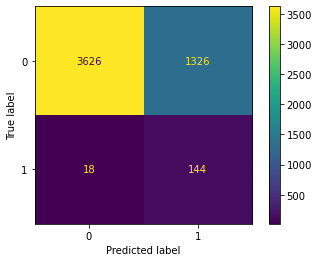

In [39]:
plot_confusion_matrix(gs_tree, X_train, y_train)

In [40]:
y_pred = gs_tree.predict(X_train)

print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.73      0.84      4952
           1       0.10      0.89      0.18       162

    accuracy                           0.74      5114
   macro avg       0.55      0.81      0.51      5114
weighted avg       0.97      0.74      0.82      5114



#### Decision Tree Results - Testing Data

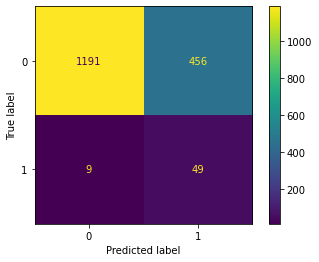

In [41]:
plot_confusion_matrix(gs_tree, X_test, y_test)

In [42]:
y_pred = gs_tree.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.72      0.84      1647
           1       0.10      0.84      0.17        58

    accuracy                           0.73      1705
   macro avg       0.54      0.78      0.51      1705
weighted avg       0.96      0.73      0.81      1705



### Interpreting the Decision Tree

While the recall went up for this model (from 0.81 to 0.84), the precision went down, from 0.18 to 0.10 and the f1-score went down from 0.30 to 0.17. 

This is a very crude model that does a good job picking out most companies that do go bankrupt, but also includes an even larger number of companies that don't go bankrupt. It's most useful for investors who want to avoid risky assets while putting the minimum possible effort into portfolio management. And on the test data it worked quite well for this purpose. While someone who invests randomly can expect losses of over 3% due to bankruptcies, investors who use this simple decision tree can expect to trim losses due to bankruptcies to only 1%. 

In the tree below, we see that the data has been filtered into four bins, two bins predicting values of 0 (no bankruptcy) and two bins predicting values of 1 (bankruptcy). Our decision tree tells us how values ended up in each of these bins, as well as the entropy of each of the bins. An entropy value of one means that the bin is evenly divided between bankruptcies and non-bankruptcies, while an entropy of zero means that the bin consists of only bankruptcies or non-bankruptcies.

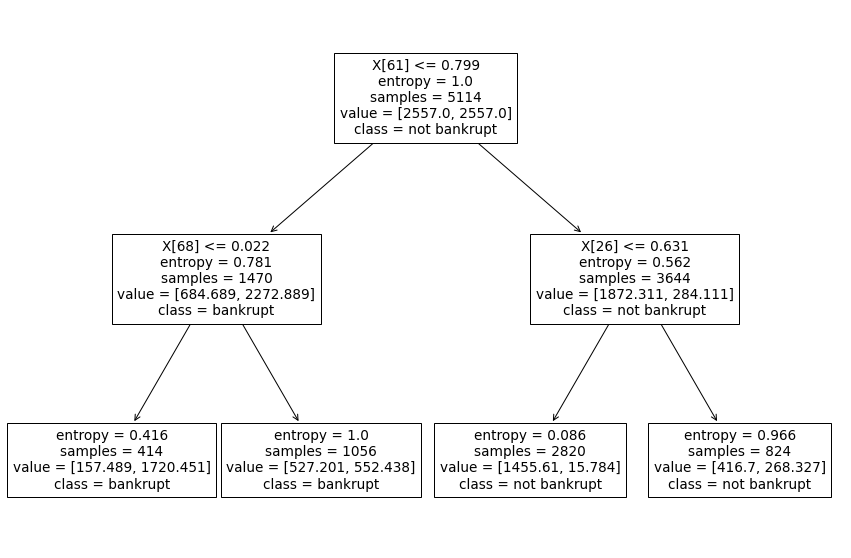

In [43]:
fig, ax = plt.subplots(figsize=(15, 10))
plot_tree(gs_tree.best_estimator_, class_names = {0: 'not bankrupt', 1: 'bankrupt'})
plt.show()

Below we can see the three features used in our decision tree, along with their relative importance.

In [44]:
features = pd.concat([pd.DataFrame(X.columns, columns=['column']), pd.DataFrame(gs_tree.best_estimator_.feature_importances_, columns=['importance'])], axis=1)
features.sort_values('importance', ascending=False).head()

,column,importance
61,Net Income to Total Assets,0.645758
68,Equity to Liability,0.182021
26,Interest Expense Ratio,0.172221
49,Total expense/Assets,0.000000
48,Total income/Total expense,0.000000


The top node divides the data between companies with higher net income to total assets ratios and companies with lower net income to total assets ratios, with lower ratios all labeled as bankruptcies and higher ratios all labeled as non-bankruptcies. While this predicts bankruptcy with a very low (10%) precision rate, it has a recall of 84%, which is unsurprising since a company with poor financial health is very likely to have a below average income relative to its size.

The next splits in our decision tree divide each of the net income/total assets nodes into two leaves--a high entropy leaf and a low entropy leaf. These leaves don't have any effect on the decision made by the algorithm. But their  entropy tells us how confident the algorithm is in its predictions. The leaves with entropy levels of 1 and 0.966 include companies that have about the same likelihood of representing bankruptcies as non-bankruptcies, while the leaves with lower entropy levels (0.416 and 0.086) represent a significantly greater likelihood of either bankruptcies or non-bankruptcies.

### Inside the Decision Tree

Below we can see the relevant statistics for the first five rows of test data as well as the predictions made by the decision tree algorithm on this data.

In [45]:
stats = X_test.iloc[:5, [61, 68, 26]]
index_rows = list(X_test.iloc[:5, :].index)
predictions = pd.DataFrame(gs_tree.predict(X_test.iloc[:5,:]), columns=['predictions'], index=index_rows)
values = pd.DataFrame(y_test).iloc[:5,:]
probabilities = pd.DataFrame([n[1] for n in gs_tree.predict_proba(X_test.iloc[:5,:])], columns=['probabilities'], index=index_rows)
pd.concat([stats, probabilities, predictions, values], axis=1)

,Net Income to Total Assets,Equity to Liability,Interest Expense Ratio,probabilities,predictions,Bankrupt?
239,0.765336,0.087378,0.630611,0.511688,1,0
2850,0.817797,0.028519,0.631052,0.010727,0,0
2687,0.847518,0.048876,0.630615,0.010727,0,0
6500,0.767650,0.014691,0.630033,0.916137,1,1
2684,0.810394,0.019245,0.632175,0.391703,0,0


Here we  get the same true positive as we got for the logistic regression, while we have a different false positive. Both these companies have a low net income to assets ratio which is why both of them are labeled as bankrupt. However, the true positive is labeled as bankrupt with a 91.6% probability while the false positive was labeled as bankrupt with only a 51% probability. 

Just as we used the precision recall curve to evaluate the performance of probability thresholds for our logistic regression, we can also use it to evaluate the performance of probability thresholds for our decision tree. The difference is that we have a set of four precision and recall numbers for each leaf of the tree rather than a continuous probability function that has a different value at each point.

Below we can see how the leaf with a 91.6% probability prediction yielded 107 false positives and only 39 true positives.

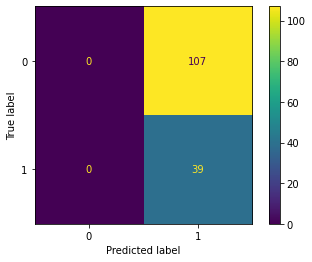

In [48]:
y_probs = [n[1] for n in gs_tree.predict_proba(X_test)]

# getting precision recall curve

probs_df = pd.DataFrame(y_probs, index=list(y_test.index), columns=['probabilities'])
y_preds_df = pd.DataFrame(gs_tree.predict(X_test), index=list(y_test.index), columns=['predictions'])
y_true_df = pd.DataFrame(y_test)
dataframe = pd.concat([probs_df, y_preds_df, y_true_df], axis=1)

highest_threshold_indices = list(dataframe[dataframe['probabilities']>0.9].index)

plot_confusion_matrix(gs_tree, X_test.loc[highest_threshold_indices,:], y_test[highest_threshold_indices])
plt.show()

On the other had, the leaf with a 0.01% probability prediction yielded 0 false negatives.

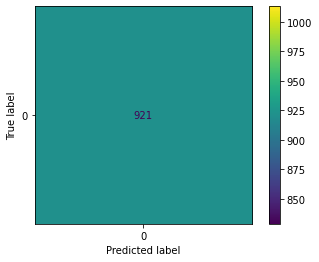

In [50]:
highest_threshold_indices = list(dataframe[dataframe['probabilities']<0.2].index)

plot_confusion_matrix(gs_tree, X_test.loc[highest_threshold_indices,:], y_test[highest_threshold_indices])
plt.show()

These confusion matrices show that while our model works well for picking out safe investments, it doesn't perform very well at picking out bankruptcies with precision, which is useful if we're trying to short sell stocks. In this sense, the Logistic Regression model is more effective since its complexity allows us to more finely tune our precision/recall trade off based on probability thresholds.

## Decision Tree Classifier #2

With our second decision tree classifier, we'll test out trees with greater depth and with minimum weight fractions for each leaf. I'm using weight fractions rather than sizes because weight fractions take into account the weight balancing that gives a greater weight to the minority class.

In [51]:
tree = DecisionTreeClassifier(random_state=42, class_weight='balanced')

grid = [{'criterion': ['entropy', 'gini'],
         'max_depth': [5, 6, 7],
         'min_weight_fraction_leaf': [np.e**n for n in range(-5, 0)],
         'max_features': ['sqrt', 'log2']
        }]
gs_tree_2 = GridSearchCV(estimator=tree, param_grid=grid, scoring='f1', cv=5)

In [52]:
gs_tree_2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid=[{'criterion': ['entropy', 'gini'],
                          'max_depth': [5, 6, 7],
                          'max_features': ['sqrt', 'log2'],
                          'min_weight_fraction_leaf': [0.006737946999085469,
                                                       0.018315638888734186,
                                                       0.04978706836786395,
                                                       0.1353352832366127,
                                                       0.36787944117144233]}],
             scoring='f1')

In [53]:
gs_tree_2.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'sqrt',
 'min_weight_fraction_leaf': 0.006737946999085469}

#### Decision Tree #2: Training Data

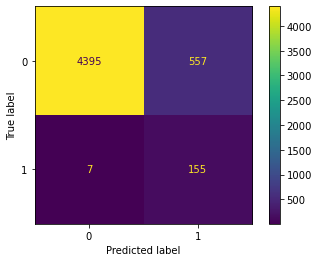

In [54]:
plot_confusion_matrix(gs_tree_2, X_train, y_train)

In [55]:
y_pred = gs_tree_2.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94      4952
           1       0.22      0.96      0.35       162

    accuracy                           0.89      5114
   macro avg       0.61      0.92      0.65      5114
weighted avg       0.97      0.89      0.92      5114



#### Decision Tree #2: Test Data

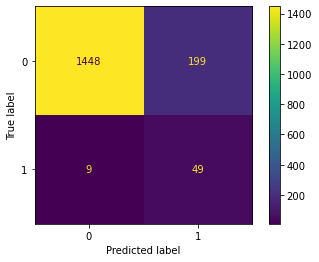

In [56]:
plot_confusion_matrix(gs_tree_2, X_test, y_test)

In [57]:
y_pred = gs_tree_2.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93      1647
           1       0.20      0.84      0.32        58

    accuracy                           0.88      1705
   macro avg       0.60      0.86      0.63      1705
weighted avg       0.97      0.88      0.91      1705



This model both has a significantly improved f1 score compared to the simple decision tree model and the larger number of leaves means that it has a larger number of probability thresholds, which is useful if we want to divide companies into more than two risk classes as we're able to do with the logistic regression model. Its performance on the testing data is not much worse than its performance on the training data, which is good because it means that we can trust that the decision tree hasn't been overfit on the training data. Below we can see the number of predictions at each probability threshold (where >0.5 predicts bankruptcy and <0.5 predicts no bankruptcy). 

In [59]:
predictions = pd.DataFrame(gs_tree_2.predict_proba(X_test), columns=['no bankruptcy','bankruptcy'])
predictions['bankruptcy'].value_counts()

0.000000    1336
0.905867      51
0.971225      35
0.245391      33
0.379405      29
0.374754      24
0.550100      22
0.452403      20
0.598574      17
0.898278      16
0.897264      16
0.670821      16
0.326692      15
0.799483      14
0.678263      11
0.772543      10
0.813671      10
0.656416       8
0.930023       6
0.693655       6
0.983906       3
0.824646       3
0.964503       2
0.792574       2
Name: bankruptcy, dtype: int64

In [60]:
y_probs = [n[1] for n in gs_tree_2.predict_proba(X_test)]

# getting precision recall curve

probs_df = pd.DataFrame(y_probs, index=list(y_test.index), columns=['probabilities'])
y_preds_df = pd.DataFrame(gs_tree_2.predict(X_test), index=list(y_test.index), columns=['predictions'])
y_true_df = pd.DataFrame(y_test)
dataframe = pd.concat([probs_df, y_preds_df, y_true_df], axis=1)
dataframe.head()

,probabilities,predictions,Bankrupt?
239,0.000000,0,0
2850,0.000000,0,0
2687,0.000000,0,0
6500,0.905867,1,1
2684,0.000000,0,0


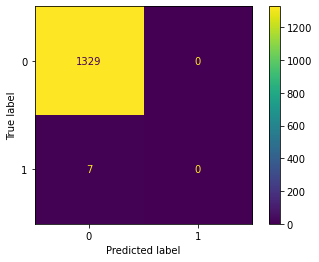

In [61]:
lowest_threshold_indices = list(dataframe[dataframe['probabilities']<0.245391].index)

plot_confusion_matrix(gs_tree_2, X_test.loc[lowest_threshold_indices,:], y_test[lowest_threshold_indices])

As we see here, if we invested solely in stocks at below a 24.5% bankruptcy probability threshold, we would have lost around 0.5% of their value to bankruptcies.

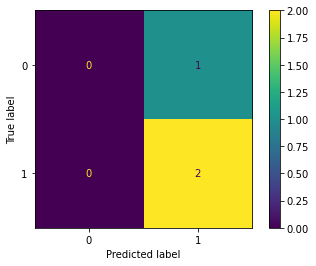

In [62]:
highest_threshold_indices = list(dataframe[dataframe['probabilities']>0.983906].index)

plot_confusion_matrix(gs_tree_2, X_test.loc[highest_threshold_indices,:], y_test[highest_threshold_indices])

Conversely, if we had shorted the stocks of companies with bankruptcy probabilities of the highest threshold (98.4%), two out of three would have in fact gone bankrupt.

## Random Forest Classifier

A random forest classifier uses multiple decision trees each trained on different randomly selected samples of the training data, and limited to a different set of randomly chosen features. Then the classifier counts the predictions for each data point and labels the data point according to the value predicted by the largest number of trees.

In [63]:
rfc = RandomForestClassifier(class_weight='balanced', random_state=42)

grid = [{'criterion': ['entropy', 'gini'],
        'n_estimators': [30, 40, 50],
        'max_depth': [2, 3, 4],
        'max_features': ['auto','log2']}]

gs_rfc = GridSearchCV(estimator=rfc, param_grid=grid, scoring='f1', cv=5)

In [64]:
gs_rfc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid=[{'criterion': ['entropy', 'gini'],
                          'max_depth': [2, 3, 4],
                          'max_features': ['auto', 'log2'],
                          'n_estimators': [30, 40, 50]}],
             scoring='f1')

In [65]:
gs_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 40}

#### Random Forest Results - Training Data

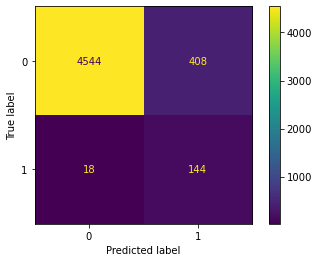

In [66]:
plot_confusion_matrix(gs_rfc, X_train, y_train)

In [67]:
y_pred = gs_rfc.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96      4952
           1       0.26      0.89      0.40       162

    accuracy                           0.92      5114
   macro avg       0.63      0.90      0.68      5114
weighted avg       0.97      0.92      0.94      5114



#### Random Forest Results - Test Data

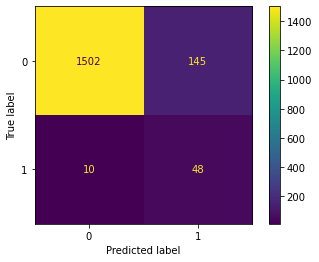

In [68]:
plot_confusion_matrix(gs_rfc, X_test, y_test)

In [69]:
y_pred = gs_rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      1647
           1       0.25      0.83      0.38        58

    accuracy                           0.91      1705
   macro avg       0.62      0.87      0.67      1705
weighted avg       0.97      0.91      0.93      1705



#### Listing all probability values with value counts

In [70]:
predictions = pd.DataFrame(gs_rfc.predict_proba(X_test), columns=['no bankruptcy','bankruptcy'])
predictions['bankruptcy'].value_counts()

0.000494    196
0.001812     79
0.002246     77
0.003593     22
0.003564     16
           ... 
0.022407      1
0.006010      1
0.168260      1
0.157549      1
0.033026      1
Name: bankruptcy, Length: 1202, dtype: int64

The fact that there are more probability values in the Random Forest's probability function means that we can use our model to make more fine grained distinctions between risk thresholds.

#### Model Performance on First Five Rows

In [73]:
y_probs = [n[1] for n in gs_rfc.predict_proba(X_test)]

# getting precision recall curve

probs_df = pd.DataFrame(y_probs, index=list(y_test.index), columns=['probabilities'])
y_preds_df = pd.DataFrame(gs_rfc.predict(X_test), index=list(y_test.index), columns=['predictions'])
y_true_df = pd.DataFrame(y_test)
dataframe = pd.concat([probs_df, y_preds_df, y_true_df], axis=1)
dataframe.head()

,probabilities,predictions,Bankrupt?
239,0.270793,0,0
2850,0.019623,0,0
2687,0.003593,0,0
6500,0.881361,1,1
2684,0.394425,0,0


The Random Forest performed perfectly on the first five rows of test data.

#### Precision at >94% threshold

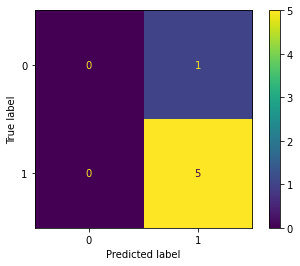

In [74]:
highest_threshold_indices = list(dataframe[dataframe['probabilities']>=0.94].index)

plot_confusion_matrix(gs_rfc, X_test.loc[highest_threshold_indices,:], y_test[highest_threshold_indices])

#### Precision at <6% threshold

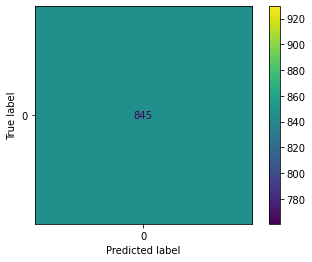

In [75]:
lowest_threshold_indices = list(dataframe[dataframe['probabilities']<0.06].index)

plot_confusion_matrix(gs_rfc, X_test.loc[lowest_threshold_indices,:], y_test[lowest_threshold_indices])

The random forest model performs slightly better than our second decision tree model at the 50% threshold. However, a big part of its power comes from the fact that it is able to predict with much greater recall and precision at high and low thresholds. It is also superior to our logistic regression model at the 94% threshold. The logistic regression model had a false positive rate of 50% at this threshold compared to the Random Forest which had a false positive rate of under 17% at this threshold.

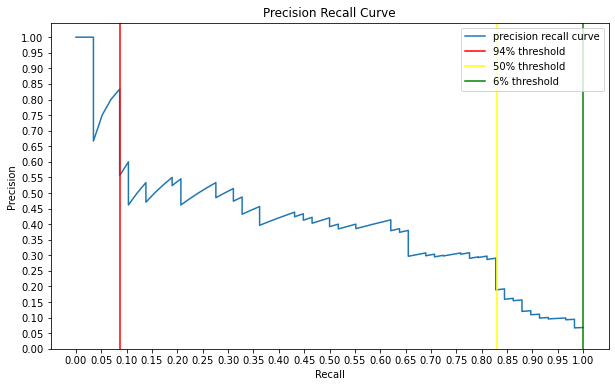

In [322]:
#getting probabilities for decision function

y_probs = [n[1] for n in gs_rfc.predict_proba(X_test)]

# getting precision recall curve

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(recall, precision, label='precision recall curve')

ax.set_yticks([i/20.0 for i in range(21)])
ax.set_xticks([i/20.0 for i in range(21)])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall Curve')
ax.axvline(x=5/58, label='94% threshold', color='red')
ax.axvline(x=0.83, label='50% threshold', color='yellow')
ax.axvline(x=1, label='6% threshold', color='green')
plt.legend(loc='upper right')

In [323]:
thresholds_df = pd.DataFrame(thresholds.reshape(-1,1), columns=['thresholds'])
precision_df = pd.DataFrame(precision.reshape(-1,1), columns=['precision'])
recall_df = pd.DataFrame(recall.reshape(-1,1), columns=['recall'])

precision_recall_df = pd.concat([thresholds_df, recall_df, precision_df], axis=1)
precision_recall_df.sort_values('precision', ascending=False)[(precision_recall_df['precision']>0.499)&(precision_recall_df['precision']<0.501)]

/var/folders/gs/xqppcy254vd2q7ybhjlcr_pr0000gn/T/ipykernel_1074/1560636972.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  precision_recall_df.sort_values('precision', ascending=False)[(precision_recall_df['precision']>0.499)&(precision_recall_df['precision']<0.501)]


,thresholds,recall,precision
832,0.917741,0.155172,0.5
822,0.907370,0.241379,0.5
814,0.877738,0.310345,0.5
816,0.883500,0.293103,0.5
818,0.886218,0.275862,0.5
836,0.924378,0.120690,0.5
838,0.926928,0.103448,0.5
826,0.914734,0.206897,0.5
834,0.919585,0.137931,0.5


We see here that we get a 50% precision for a range of probability values, from 88.35% to 92.69%

## XGBoost

The last algorithm I tested was XGBoost, which uses a succession of weak learner tree algorithms that train on their predecessor's weaknesses to make a progressively stronger predictions. 

In [76]:
from xgboost import XGBClassifier

In [287]:
grid = {
    'max_depth': [2, 3, 4],
    'n_estimators': [150, 160, 170, 180, 190],
    'reg_lambda': [np.e**n for n in range(0, 6)]
}

ratio = y_train.value_counts()[0]/y_train.value_counts()[1]

xgb_clf = XGBClassifier(use_label_encoder=False, random_state=42, eval_metric='logloss', scale_pos_weight=ratio)

gs_xgb = GridSearchCV(estimator=xgb_clf, param_grid=grid, cv=5, scoring='f1')

In [288]:
gs_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, mono...
                                     random_state=42, reg_alpha=None,
                                     reg_lambda=None,
                                     scale_pos_weight=30.567901234567902,
                                     subsample=N

In [289]:
gs_xgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=160, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=54.59815003314423,
              scale_pos_weight=30.567901234567902, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

#### XGBoost Results - Training Data

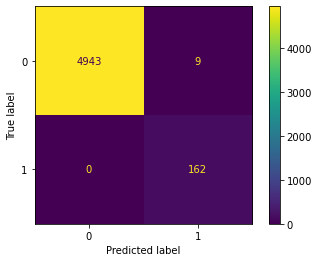

In [290]:
plot_confusion_matrix(gs_xgb, X_train, y_train)

In [291]:
y_pred = gs_xgb.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4952
           1       0.95      1.00      0.97       162

    accuracy                           1.00      5114
   macro avg       0.97      1.00      0.99      5114
weighted avg       1.00      1.00      1.00      5114



#### XGBoost Results - Testing Data

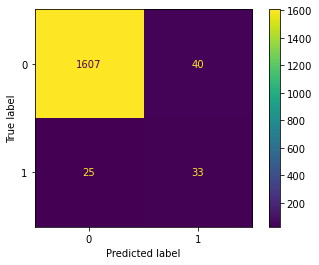

In [292]:
plot_confusion_matrix(gs_xgb, X_test, y_test)

In [293]:
y_pred = gs_xgb.predict(X_test)

In [294]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1647
           1       0.45      0.57      0.50        58

    accuracy                           0.96      1705
   macro avg       0.72      0.77      0.74      1705
weighted avg       0.97      0.96      0.96      1705



In [295]:
y_probs = [n[1] for n in gs_xgb.predict_proba(X_test)]

# getting precision recall curve

probs_df = pd.DataFrame(y_probs, index=list(y_test.index), columns=['probabilities'])
y_preds_df = pd.DataFrame(gs_rfc.predict(X_test), index=list(y_test.index), columns=['predictions'])
y_true_df = pd.DataFrame(y_test)
dataframe = pd.concat([probs_df, y_preds_df, y_true_df], axis=1)
dataframe.head()

,probabilities,predictions,Bankrupt?
239,0.000374,0,0
2850,0.000161,0,0
2687,0.000184,0,0
6500,0.123737,1,1
2684,0.018734,0,0


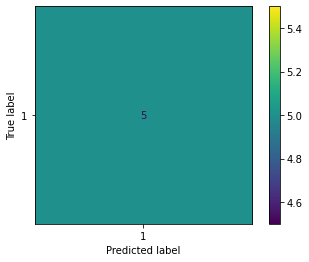

In [318]:
highest_threshold_indices = list(dataframe[dataframe['probabilities']>=0.97].index)

plot_confusion_matrix(gs_xgb, X_test.loc[highest_threshold_indices,:], y_test[highest_threshold_indices])

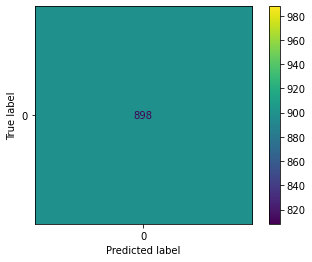

In [306]:
low_threshold_indices = list(dataframe[dataframe['probabilities']<0.0008].index)

plot_confusion_matrix(gs_xgb, X_test.loc[low_threshold_indices,:], y_test[low_threshold_indices])

The above confusion matrices show that at above a 97% probability threshold, we are able to pick out almost 10% of bankruptcies without any false positives. Below a 0.08% thresholds we were able to pick out a 898 companies, none of which went bankrupt.

### Precision Recall Curve

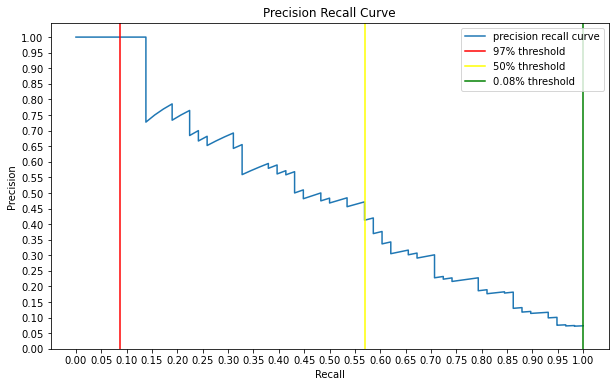

In [324]:
#getting probabilities for decision function

y_probs = [n[1] for n in gs_xgb.predict_proba(X_test)]

# getting precision recall curve

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(recall, precision, label='precision recall curve')

ax.set_yticks([i/20.0 for i in range(21)])
ax.set_xticks([i/20.0 for i in range(21)])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall Curve')
ax.axvline(x=5/58, label='97% threshold', color='red')
ax.axvline(x=0.57, label='50% threshold', color='yellow')
ax.axvline(x=1, label='0.08% threshold', color='green')
plt.legend(loc='upper right')

With an f1 score of 50% this is definitely our best model, though even with regularization it appears to be overfitting on the data. It has a high recall at low probability thresholds and a high precision at high probability thresholds, which makes up for its lower recall at the 50% threshold. This is not necessarily a bad thing, since we've raised our precision at the 50% threshold and are therefore avoiding too many false positives. 

In [321]:
thresholds_df = pd.DataFrame(thresholds.reshape(-1,1), columns=['thresholds'])
precision_df = pd.DataFrame(precision.reshape(-1,1), columns=['precision'])
recall_df = pd.DataFrame(recall.reshape(-1,1), columns=['recall'])

precision_recall_df = pd.concat([thresholds_df, recall_df, precision_df], axis=1)
precision_recall_df.sort_values('precision', ascending=False)[(precision_recall_df['precision']>0.499)&(precision_recall_df['precision']<0.501)]

/var/folders/gs/xqppcy254vd2q7ybhjlcr_pr0000gn/T/ipykernel_1074/1560636972.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  precision_recall_df.sort_values('precision', ascending=False)[(precision_recall_df['precision']>0.499)&(precision_recall_df['precision']<0.501)]


,thresholds,recall,precision
734,0.646736,0.448276,0.5
730,0.609431,0.482759,0.5
736,0.663963,0.431034,0.5


In this model, we get 50% precision at probabilities of 61%-66%. This is much better than our Linear Regression model, for example, where we got this level of precision only above 94.36% probability and our Random Forest model where we got this level of precision at between 88 and 92% probability.

In [334]:
dataframe[dataframe['probabilities']>0.663963].sum()

probabilities    42.278595
predictions      49.000000
Bankrupt?        25.000000
dtype: float64

As we see here, if we shorted all 49 of the companies above the 66.4% probability threshold, slightly more than half of them would go bankrupt. There's a chance that all gains could be wiped out by the appreciation in value of the other 24 companies, but the essential point is that if we were trying to choose a certain number of stocks to short, we would have done better using this model as a guide compared to any of our other models.